# Metadata-aware data analysis with cf-python and cf-plot

----

## Context and learning objectives

### What are the NCAS CF Data Tools and why do they all have 'cf' in the name?

The _NCAS CF Data Tools_ are a suite of complementary Python libraries which are designed to facilitate working with data for research in the earth sciences and aligned domains. The two that are of most relevance to the average user, and those wanting to process, analyse and visualise atmospheric data, are *cf-python* (https://ncas-cms.github.io/cf-python/), for data analysis, and *cf-plot* (https://ncas-cms.github.io/cf-plot/build/), for data visualisation. We will be focusing on use of cf-python and cf-plot today.

The 'cf' in the names of the NCAS CF Data Tools corresponds to the _CF Conventions_, a metadata standard, because they are built around this standard in the form of using the CF Data Model, which as well as performance is considered a 'unique selling point' of the tools.


### What are the CF Conventions?

The _CF Conventions_, usually referred to in this way but also know by the full name of the **C**limate and **F**orecast (CF) metadata conventions, are a metadata standard which is becoming the de-facto convention to cover the description of geoscientific data so that sharing and intercomparison is simpler. See https://cfconventions.org/ for more information.


### What are we going to learn in this session?

Our **learning aim** is to be able to use the NCAS CF Data Tools Python libraries, namely cf-python and cf-plot to process, analyse and visualise netCDF and PP datasets, whilst appreciating the context and 'unique selling point' of the libraries as being built to use the CF Conventions, a metadata standard for earth science data, to make it simpler to do what you want to do with the datasets, by working on top of a Data Model for CF.

We have **three distinct objectives**, matching the sections in this notebook. By the end of this lesson you should be familiar and have practiced using cf-python and cf-plot to do the following.

1. **Reading, basic editing and writing of netCDF**: read in netCDF files, create a new field construct by modification of data and metadata and then write out the new field to a new netCDF file.
2. **Basic data analysis, with plotting of results**: Plot the data before and after applying statistical collapses.
3. **Regridding domains, with plotting of results**:  plot the data before and after regridding across spherical and cartesian coordinate systems.

## 0. Setting up

**In this section we set up this Notebook, import the libraries and check the data we will work with, ready to use the libraries within this notebook.**

Run some set up for nice outputs in this Jupyter Notebook (not required in interactive Python or a script):

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Import cf-python and cf-plot:

In [2]:
import cfplot as cfp
import cf

Inspect the versions of cf-python and cf-plot and the version of the CF Conventions those are matched to:

In [3]:
print("cf-python version is:", cf.__version__)
print("cf-plot version is:", cfp.__version__)
print("CF Conventions version is:", cf.CF())

cf-python version is: 3.19.0
cf-plot version is: 3.4.0
CF Conventions version is: 1.13


<div class="alert alert-block alert-info">
<i>Note:</i> you can work with data compliant by any other version of the CF Conventions, or without (much) compliance, but the CF Conventions version gives the maximum version that these versions of the tools understand the features of.
</div>

Finally, see what datasets we have to explore:

<div class="alert alert-block alert-info">
<i>Note:</i> in a Jupyter Notebook, '!' precedes a shell command, so this is a terminal command and not Python
</div>

In [4]:
!ls ../../ncas_data

160by320griddata.nc			   precip_2010.nc
aaaaoa.pmh8dec.pp			   precip_DJF_means.nc
alpine_precip_DJF_means.nc		   qbo.nc
data1.nc				   regions.nc
data1-updated.nc			   rgp.nc
data2.nc				   sea_currents_backup.nc
data3.nc				   sea_currents.nc
data5.nc				   ta.nc
ggas2014121200_00-18.nc			   tripolar.nc
IPSL-CM5A-LR_r1i1p1_tas_n96_rcp45_mnth.nc  two_fields.nc
land.nc					   ua.nc
model_precip_DJF_means_low_res.nc	   u_n216.nc
model_precip_DJF_means.nc		   u_n96.nc
n2o_emissions.nc			   vaAMIPlcd_DJF.nc
POLCOMS_WAM_ZUV_01_16012006.nc		   va.nc
precip_1D_monthly.nc			   wapAMIPlcd_DJF.nc
precip_1D_yearly.nc


----

## 1. Reading, basic editing and writing of netCDF

### Read in netCDF files, create a new field construct by modification of data and metadata and then write out the new field to a new netCDF file

Read a chosen data file. Sometimes datasets have descriptive names but this one doesn't, so let's find out what it is!

In [54]:
fieldlist = cf.read('../../ncas_data/data1.nc')

See the 'fieldlist' that cf-python interprets from the data read in:

In [55]:
fieldlist

[<CF Field: long_name=Potential vorticity(time(1), pressure(23), latitude(160), longitude(320)) K m**2 kg**-1 s**-1>,
 <CF Field: air_temperature(time(1), pressure(23), latitude(160), longitude(320)) K>,
 <CF Field: eastward_wind(time(1), pressure(23), latitude(160), longitude(320)) m s**-1>,
 <CF Field: northward_wind(time(1), pressure(23), latitude(160), longitude(320)) m s**-1>]

Select a particular field from the fieldlist of interest:

In [56]:
field = fieldlist[0]

View the field with **minimal detail**, i.e. a one-line summary:

In [57]:
field  # minimal detail view

<CF Field: long_name=Potential vorticity(time(1), pressure(23), latitude(160), longitude(320)) K m**2 kg**-1 s**-1>

Or you can view it with a **medium level of detail** with the Python built-in `print` function:

In [58]:
print(field)  # view with more detail

Field: long_name=Potential vorticity (ncvar%PV)
-----------------------------------------------
Data            : long_name=Potential vorticity(time(1), pressure(23), latitude(160), longitude(320)) K m**2 kg**-1 s**-1
Dimension coords: time(1) = [1964-01-21 00:00:00]
                : pressure(23) = [1000.0, ..., 1.0] mbar
                : latitude(160) = [89.14151763916016, ..., -89.14151763916016] degrees_north
                : longitude(320) = [0.0, ..., 358.875] degrees_east


A final option is to view it with **maximal detail** using the `dump()` method:

In [59]:
field.dump()   # maximal detail!

-----------------------------------------------
Field: long_name=Potential vorticity (ncvar%PV)
-----------------------------------------------
Conventions = 'CF-1.7'
_FillValue = np.float32(2e+20)
date = '21/01/64'
history = 'Sun Sep 16 11:26:16 BST 2012 - CONVSH V1.92 16-February-2006'
long_name = 'Potential vorticity'
missing_value = np.float32(2e+20)
name = 'PV'
source = 'GRIB data'
time = '00:00'
title = 'Potential vorticity'
units = 'K m**2 kg**-1 s**-1'
valid_max = np.float32(0.018913519)
valid_min = np.float32(-0.008174051)

Data(time(1), pressure(23), latitude(160), longitude(320)) = [[[[1.3371172826737165e-06, ..., -0.0072057610377669334]]]] K m**2 kg**-1 s**-1

Domain Axis: latitude(160)
Domain Axis: longitude(320)
Domain Axis: pressure(23)
Domain Axis: time(1)

Dimension coordinate: time
    long_name = 't'
    standard_name = 'time'
    time_origin = '21-JAN-1964:00:00:00'
    units = 'days since 1964-01-21 00:00:00'
    Data(time(1)) = [1964-01-21 00:00:00]

Dimension coo

You can also inspect any of the metadata constructs or any data - the main array for the field variable, or data arrays for any metadata construct - separately, but in the interests of time we won't show this.

What if we want to change the field in some way? Let's look at an example that illustrates metadata awareness that cf-python provides. We will square the field's data and see how the units and standard name of the variable are adapted after this operation.

First, perform the squaring of the data corresponding to the field variable (note any arithmetic performed on the field object in cf-python is designed as a convenience for operating on the field's data specifically):

In [63]:
squared_field = field**2  # equivalently, = field * field

Let's compare the data of the field and the squared field, to show that the values were squared as intended. To access a field's data, you use the `.data` attribute (or `get_data()` method - I show both here):

In [67]:
print(field.data)  # or .get_data()
print(squared_field.get_data())  # or .data

[[[[1.3371172826737165e-06, ..., -0.0072057610377669334]]]] K m**2 kg**-1 s**-1
[[[[1.7878826674352921e-12, ..., 5.192299067857675e-05]]]] m4.kg-2.s-2.K2


They were indeed, but notice also that the units changed! This is because the squaring operation logically means that the units are no longer the original value `K m**2 kg**-1 s**-1` but the square of that, namely `m4.kg-2.s-2.K2` (ignore the formatting difference which is due to a quirk of the units database representation).

In this way, cf-python makes adaptations to the metadata of the field appropriate to any operations you perform, to keep the metadata up to date. A further illustration of this is how it realises that squaring the field means that its 'standard name' value is no longer applicable, so it removes it. Before it was:

We can write out field constructs to new netCDF files in any combination we wish. Let's write the squared field to a netCDF file, which we do with the `write` method like so:

In [70]:
cf.write(squared_field, 'squared_pv.nc')

To check this worked, we can run a few commands to show the files in the current working directory and then inspect the netCDF using `ncdump` command (alternatively, re-`read` with cf-python as above but with this new file):

In [73]:
# Note that in IPython ! precedes a shell command
!ls

cf_data_tools_summary_bad.ipynb  demo_in_under_an_hour.ipynb  squared_pv.nc
cf_data_tools_summary.ipynb	 squared_e_wind.nc


In [72]:
! ncdump -h squared_pv.nc

netcdf squared_pv {
dimensions:
	t = 1 ;
	p = 23 ;
	latitude = 160 ;
	longitude = 320 ;
variables:
	float t(t) ;
		t:units = "days since 1964-01-21 00:00:00" ;
		t:long_name = "t" ;
		t:standard_name = "time" ;
		t:time_origin = "21-JAN-1964:00:00:00" ;
	float p(p) ;
		p:units = "mbar" ;
		p:long_name = "p" ;
		p:standard_name = "pressure" ;
		p:positive = "down" ;
	float latitude(latitude) ;
		latitude:units = "degrees_north" ;
		latitude:long_name = "latitude" ;
		latitude:standard_name = "latitude" ;
	float longitude(longitude) ;
		longitude:units = "degrees_east" ;
		longitude:long_name = "longitude" ;
		longitude:standard_name = "longitude" ;
		longitude:modulo = " " ;
		longitude:point_spacing = "even" ;
	double PV(t, p, latitude, longitude) ;
		PV:_FillValue = 2.00000004008175e+20 ;
		PV:units = "m4.kg-2.s-2.K2" ;
		PV:name = "PV" ;
		PV:valid_min = -0.008174051f ;
		PV:missing_value = 2.00000004008175e+20 ;
		PV:valid_max = 0.01891352f ;

// global attributes:
		:Conventions = 

*In summary, we have read in a field construct from netCDF, created a new field based on the other field's data and metadata but with the data squared relative to the original, and then written in out to a netCDF file.*

----

## 2. Basic data analysis, with plotting of results

### Plot the data before and after applying statistical collapses

In [20]:
a = cf.read('../../ncas_data/qbo.nc')[0]

In [21]:
print(a)

Field: eastward_wind (ncvar%U)
------------------------------
Data            : eastward_wind(time(398), pressure(37), latitude(2), longitude(48)) m s**-1
Dimension coords: time(398) = [1979-01-16 09:00:00, ..., 2012-02-15 09:00:00] gregorian
                : pressure(37) = [1000.0, ..., 1.0] mbar
                : latitude(2) = [30.0, 0.0] degrees_north
                : longitude(48) = [0.0, ..., 352.5] degrees_east


In [22]:
b = a.collapse('maximum', axes='T')  # temporal maximum

In [23]:
print(b)

Field: eastward_wind (ncvar%U)
------------------------------
Data            : eastward_wind(time(1), pressure(37), latitude(2), longitude(48)) m s**-1
Cell methods    : time(1): maximum
Dimension coords: time(1) = [1995-08-01 21:00:00] gregorian
                : pressure(37) = [1000.0, ..., 1.0] mbar
                : latitude(2) = [30.0, 0.0] degrees_north
                : longitude(48) = [0.0, ..., 352.5] degrees_east


In [24]:
b_sub = b.subspace(X=30)
print(b)

Field: eastward_wind (ncvar%U)
------------------------------
Data            : eastward_wind(time(1), pressure(37), latitude(2), longitude(48)) m s**-1
Cell methods    : time(1): maximum
Dimension coords: time(1) = [1995-08-01 21:00:00] gregorian
                : pressure(37) = [1000.0, ..., 1.0] mbar
                : latitude(2) = [30.0, 0.0] degrees_north
                : longitude(48) = [0.0, ..., 352.5] degrees_east


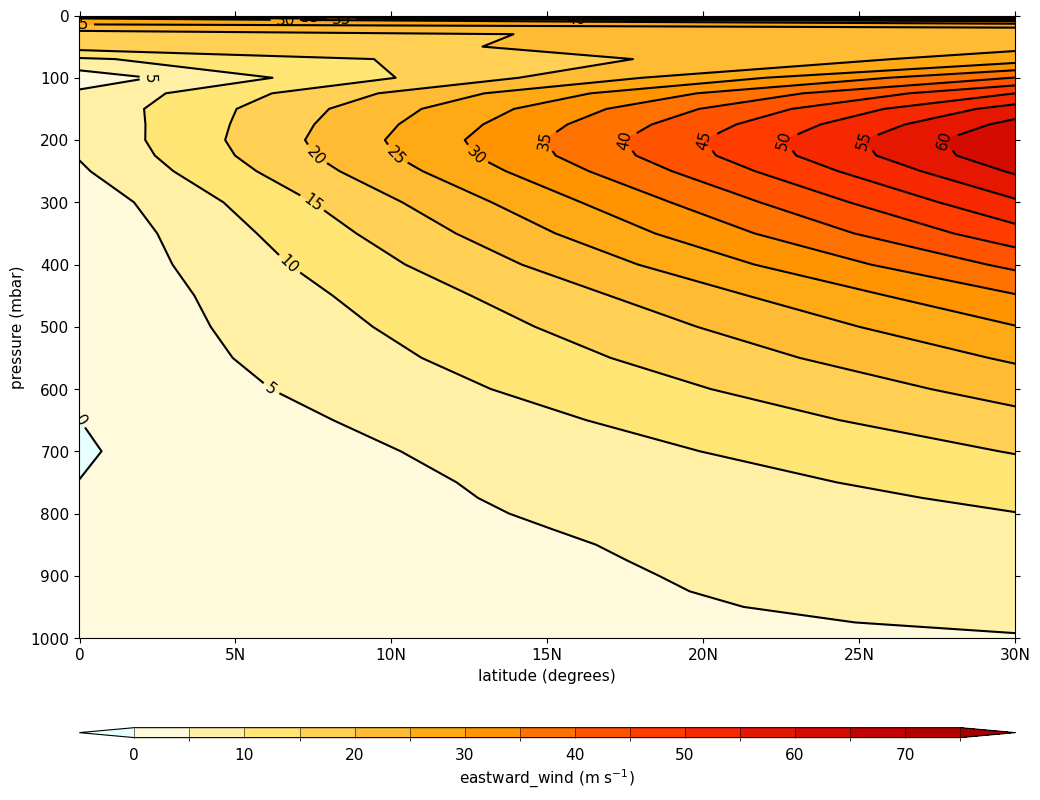

In [25]:
cfp.con(b_sub)

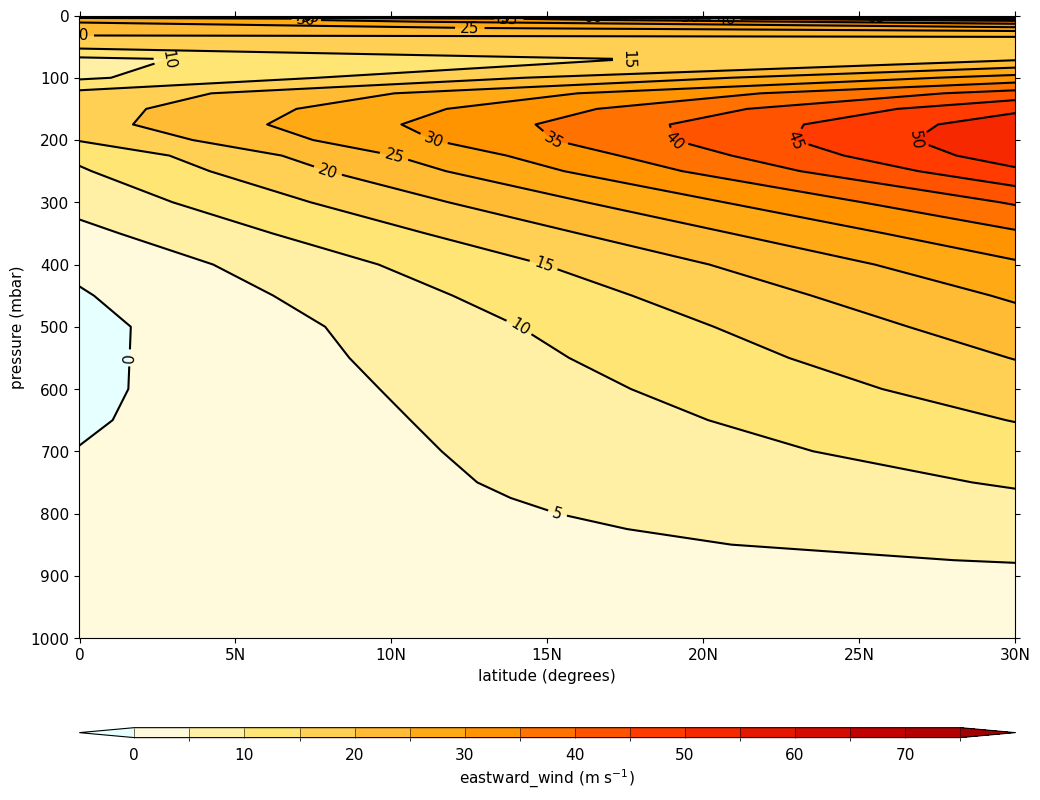

In [26]:
cfp.con(b.subspace(X=0))

In [27]:
c = a.collapse('mean', axes='X')  # horizontal mean

In [28]:
print(c)

Field: eastward_wind (ncvar%U)
------------------------------
Data            : eastward_wind(time(398), pressure(37), latitude(2), longitude(1)) m s**-1
Cell methods    : longitude(1): mean
Dimension coords: time(398) = [1979-01-16 09:00:00, ..., 2012-02-15 09:00:00] gregorian
                : pressure(37) = [1000.0, ..., 1.0] mbar
                : latitude(2) = [30.0, 0.0] degrees_north
                : longitude(1) = [176.25] degrees_east


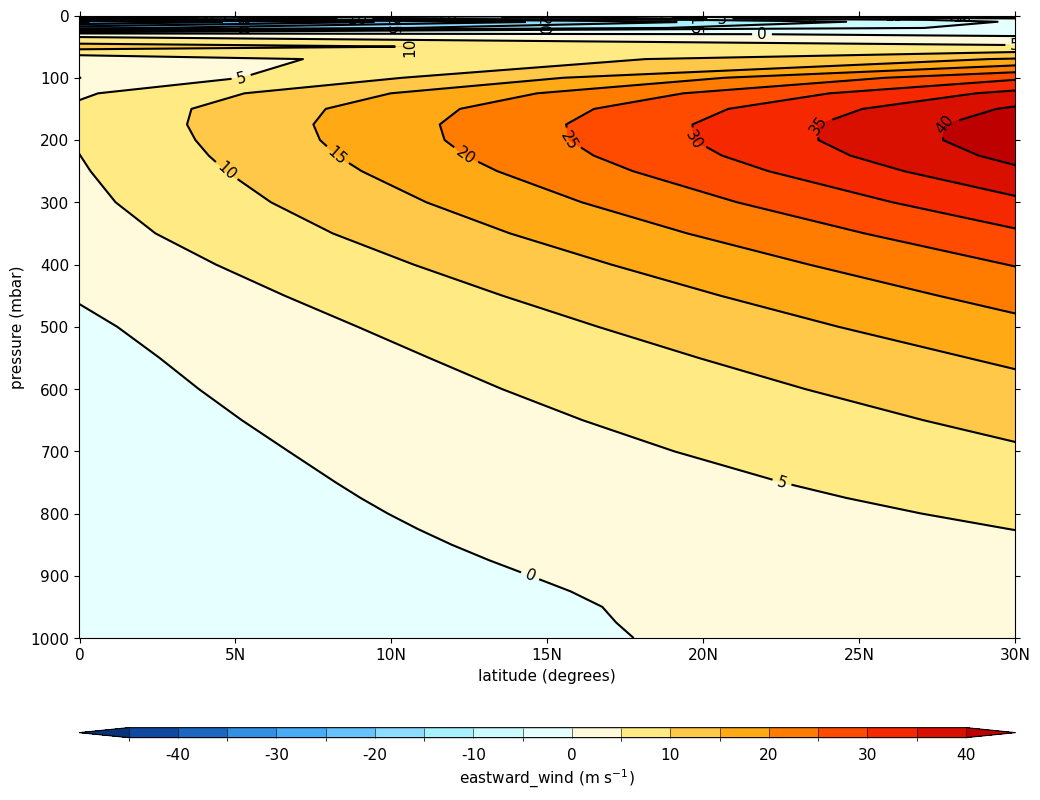

In [29]:
c_sub = c.subspace(T=cf.dt('1979-01-16 09:00:00'))

cfp.con(c_sub)

*That was a demo of some very basic statistical collapsing and sub-spacing.**

----

## 3. Regridding of fields, with plotting of results

### Plot the field before and after regridding it, to demonstrate regridding capability and multiple 

#### a) Regridding across spherical coordinate systems: conservative method as an example

Read in two fields, ``f`` and ``g``, where ``f`` is gridded at about twice the resolution of ``g``:

In [30]:
# Read in a precipitation field and inspect it
f = cf.read('../../ncas_data/precip_2010.nc')[0]
print(f)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(12), latitude(145), longitude(53)) mm
Dimension coords: long_name=time(12) = [2010-01-16 00:00:00, ..., 2010-12-16 00:00:00] gregorian
                : latitude(145) = [-90.0, ..., 90.0] degrees_north
                : longitude(53) = [-33.75, ..., 63.75] degrees_east


In [31]:
# Read in another, lower-resolution, precipitation field and inspect it
g = cf.read('../../ncas_data/model_precip_DJF_means_low_res.nc')[0]
print(g)

Field: long_name=precipitation (ncvar%precip)
---------------------------------------------
Data            : long_name=precipitation(long_name=t(1), long_name=Surface(1), latitude(73), longitude(27)) mm/day
Cell methods    : long_name=t(1): mean
Dimension coords: long_name=t(1) = [1996-07-16 00:00:00] 360_day
                : long_name=Surface(1) = [0.0] level
                : latitude(73) = [-90.0, ..., 90.0] degrees_north
                : longitude(27) = [-33.75, ..., 63.75] degrees_east


Regrid the first field to the grid of the second. We use the `regrids` method of cf-python.

In [32]:
h_1 = f.regrids(g, method='patch')
h_2 = f.regrids(g, method='conservative')
h_1.equals(h_2)

False

Now let's inspect what we have, by plotting the field "before and after" (though actually we keep two different fields) the regridding:

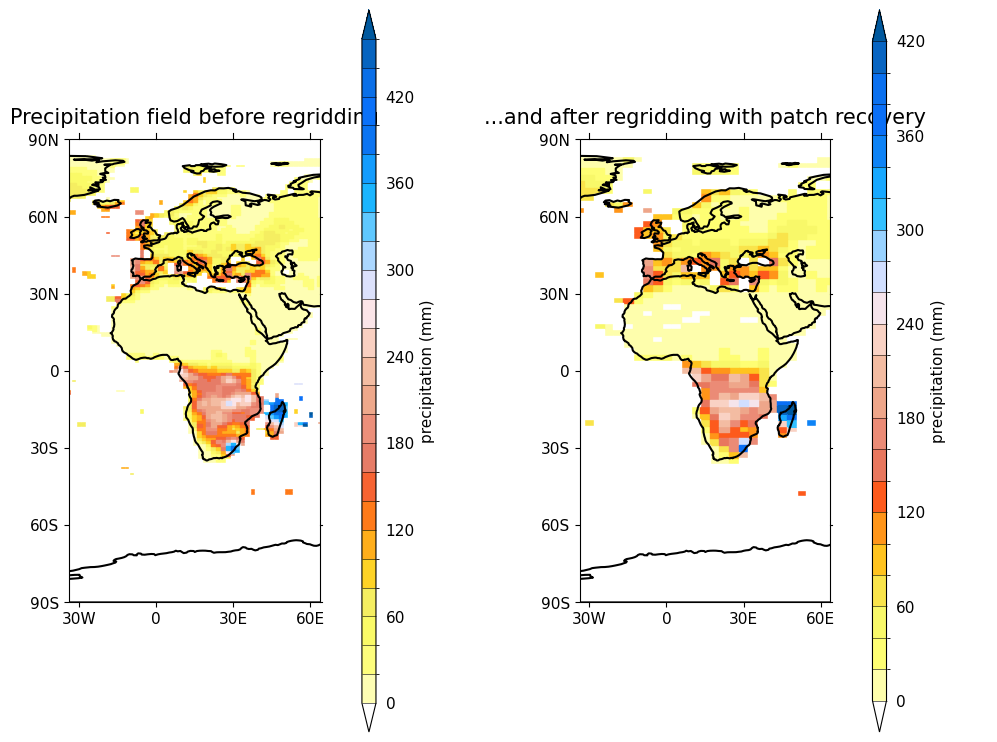

Comparing results fom different regridding methods:


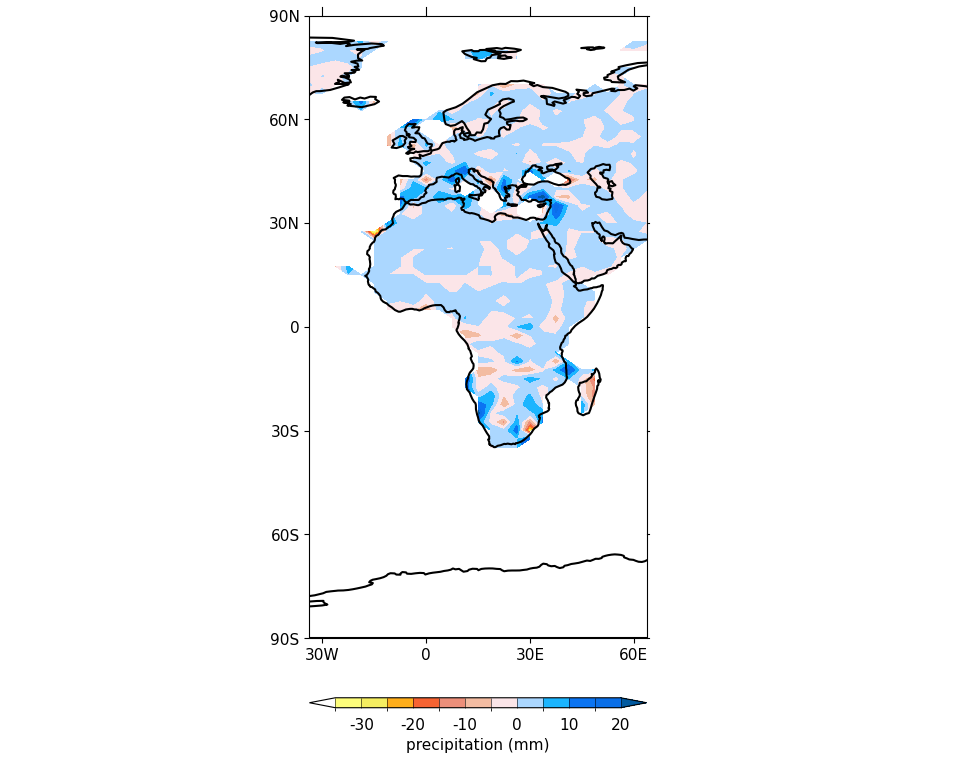

In [33]:
# Take some subspaces first:
f_sub = f[0]
h_1_sub = h_1[0]
h_2_sub = h_2[0]


# Customising the plots to look nicer
cfp.mapset()
#cfp.mapset(proj='robin')
cfp.cscale('rh_19lev')

cfp.gopen(rows=1, columns=2)
cfp.gpos(1)
cfp.con(f_sub, blockfill=True, lines=False, colorbar_orientation='vertical',
        title='Precipitation field before regridding')
cfp.gpos(2)
cfp.con(h_1_sub, blockfill=True, lines=False, colorbar_orientation='vertical',
        title='...and after regridding with patch recovery')
cfp.gclose()

print("Comparing results fom different regridding methods:")
cfp.con(h_2_sub - h_1_sub, lines=False)

As we expect, the regridded field resembles the original in its nature, but is at lower-resolution due to its new grid.

#### b) Regridding across cartesian coordinate systems: time series as an example

The term 'regridding' brings to mind a multi-dimensional grid e.g. over the earth's surface, but a 'grid' is really just a set of points in a multi-dimensional space. In 1D, this is just a series of data points.

Cartesian regridding can be used for 1 to 3 dimensions, so we can use it to "regrid" such a series, and let's use a time series as an example.

Again, start by reading in some (different) precipitation fields, in this case ``i`` and ``j`` which form a pair of time series with different domains/grids i.e. numbers of time data points:

In [34]:
# Read in a precipitation field and inspect it
i = cf.read('../../ncas_data/precip_1D_yearly.nc')[0]
print(i)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(10), long_name=latitude(1), long_name=longitude(1)) mm
Cell methods    : long_name=time(10): mean long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(10) = [1981-07-02 00:00:00, ..., 1990-07-02 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


In [35]:
j = cf.read('../../ncas_data/precip_1D_monthly.nc')[0]
print(j)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(120), long_name=latitude(1), long_name=longitude(1)) mm
Cell methods    : long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(120) = [1981-01-16 00:00:00, ..., 1990-12-16 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


Regrid linearly along the time axis 'T' and summarise the resulting field. This time, because we are working with cartesian coordinates, we need to use the `regridc` method on the field acting as the source domain.

For diversity, we use a different regridding method. Let's use linear interpolation, by setting `method='linear'`:

In [36]:
k = i.regridc(j, axes='T', method='linear')
print(k)

Field: long_name=precipitation (ncvar%pre)
------------------------------------------
Data            : long_name=precipitation(long_name=time(120), long_name=latitude(1), long_name=longitude(1)) mm
Cell methods    : long_name=time(120): mean long_name=latitude(1): long_name=longitude(1): mean
Dimension coords: long_name=time(120) = [1981-01-16 00:00:00, ..., 1990-12-16 00:00:00] gregorian
                : long_name=latitude(1) = [0.0] degrees_north
                : long_name=longitude(1) = [0.0] degrees_east


Plot the time series before and after regridding

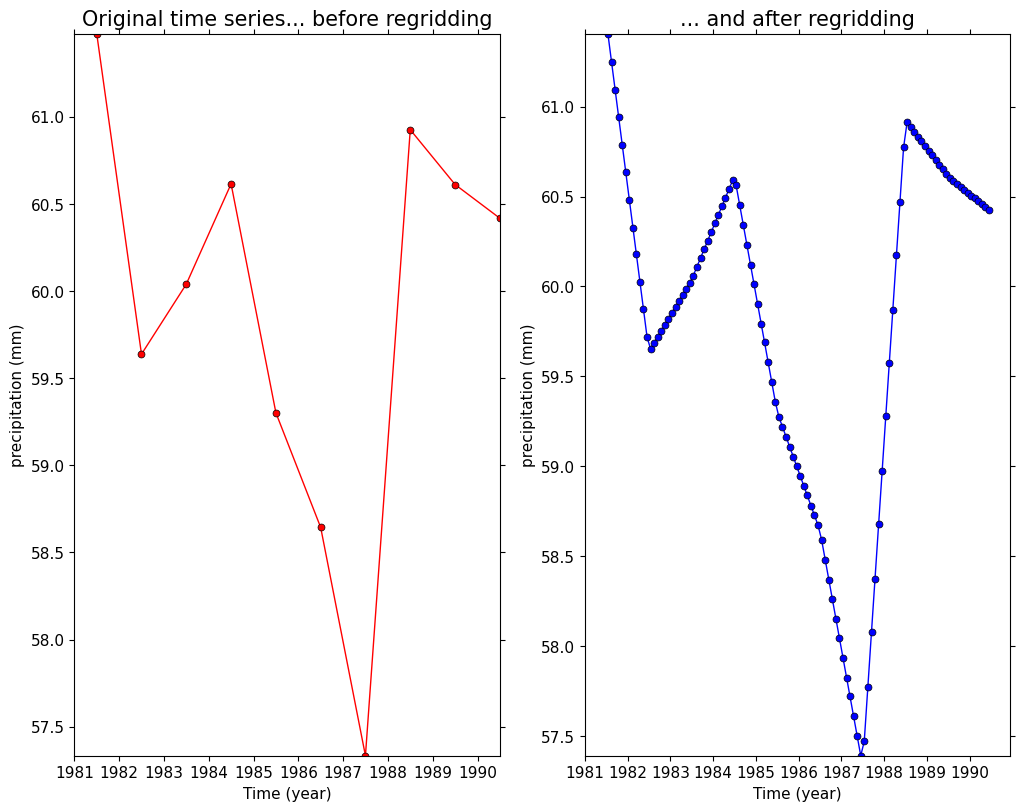

In [37]:
cfp.gopen(rows=1, columns=2)
cfp.gpos(1)
cfp.lineplot(i, marker='o', color='red',
             title='Original time series... before regridding')
cfp.gpos(2)
cfp.lineplot(k, marker='o', color='blue', title='... and after regridding')
cfp.gclose()

In this case, we've seen that regridding can apply not just to multi-dimensional coordinates but to *data series* (which are *1D "grids"*).

As you can see, again the nature of the regridding output is preserved, but the granularity has changed, in this case becoming higher.

----

## Where to find more information and resources on the NCAS CF Data Tools

Here are some links relating to the NCAS CF Data Tools and this training. The **first two are the official documentation pages**
which we advise you consult first if you want to know more:

* **The cf-python documentation lives at https://ncas-cms.github.io/cf-python/.**
* **The cf-plot documentation lives at https://ncas-cms.github.io/cf-plot/build/.**
* This training, with further material, is hosted online and there are instructions for setting up the environment so you can work through it in your own time: https://github.com/NCAS-CMS/cf-tools-training.
* The cf-python code lives on GitHub at https://github.com/NCAS-CMS/cf-python. There is an Issue Tracker to report queries or questions at https://github.com/NCAS-CMS/cf-python/issues.
* The cf-plot code lives on GitHub at https://github.com/NCAS-CMS/cf-plot. There is an Issue Tracker to report queries or questions at https://github.com/NCAS-CMS/cf-plot/issues.
* There is a technical presentation about the NCAS CF Data Tools avaialble from https://hps.vi4io.org/_media/events/2020/summer-school-cfnetcdf.pdf.
* The website of the CF Conventions can be found at https://cfconventions.org/.
* The landing page for training into the CF Conventions is found here within the website above: https://cfconventions.org/Training/.

If you have any queries after this course, please either use the Issue Trackers linked above or you can email Sadie at: sadie.bartholomew@ncas.ac.uk.

----